<a href="https://colab.research.google.com/github/cqkh42/boris_vs_keir/blob/main/Boris_vs_Keir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Boris vs Keir

Is it a bird, it a plane, is it a blonde baffoon who spends 99% of his life just winging it, or is it a knight of the realm, former Director of Public Prosecutions and real life embodiment of Mark Darcy.

Let's let the model decide.

In [1]:
!pip install -Uqq fastai
!pip install -Uqq jmd_imagescraper

     |████████████████████████████████| 194kB 14.3MB/s 
     |████████████████████████████████| 61kB 9.5MB/s 


In [2]:
import shutil
from pathlib import Path

import fastai.vision.all as vision
import fastai.vision.widgets as vision_widgets
import jmd_imagescraper.core as imagescraper
import requests

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [19]:
TARRED_DATA = Path() / 'gdrive' / 'MyDrive' / 'colab' / 'images.tar.gz'

In [20]:
import tempfile
if not TARRED_DATA.exists():
    with tempfile.TemporaryDirectory() as tmpdirname:
        print('created temporary directory', tmpdirname)
        p = Path(tmpdirname) / 'images'
        p.mkdir()
        for category in ['boris johnson', 'keir starmer']:
            imagescraper.duckduckgo_search(
                p, category, category, max_results=1000, 
                img_layout=imagescraper.ImgLayout.All
            )
        !tar --directory=$tmpdirname -czf $TARRED_DATA images/

In [21]:
!rm -rf images/
!tar -xzf $TARRED_DATA
IMAGES = Path() / 'images'
len(list(IMAGES.rglob('*')))

1504

In [22]:
vehicles = vision.DataBlock(
    blocks=(vision.ImageBlock, vision.CategoryBlock), 
    get_items=vision.get_image_files, 
    splitter=vision.RandomSplitter(valid_pct=0.2, seed=42),
    get_y=vision.parent_label,
    item_tfms=vision.RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=vision.aug_transforms()
)

In [23]:
dls = vehicles.dataloaders(IMAGES)

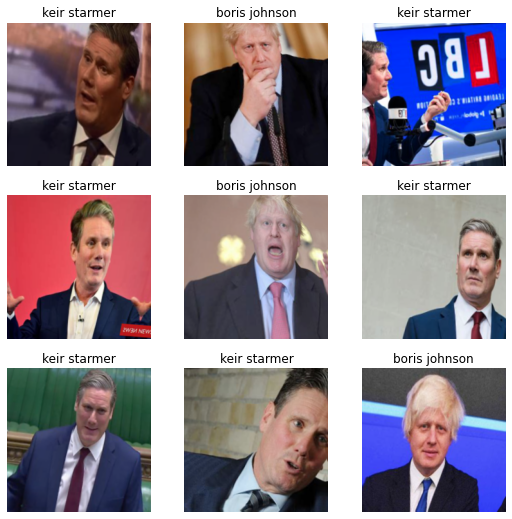

In [24]:
dls.train.show_batch()

In [25]:
learn = vision.cnn_learner(dls, vision.resnet18, metrics=vision.error_rate)
learn.fine_tune(4)

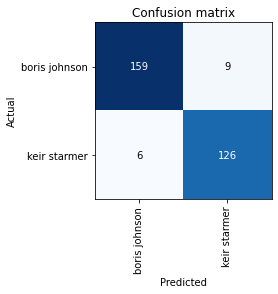

In [26]:
interp = vision.ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

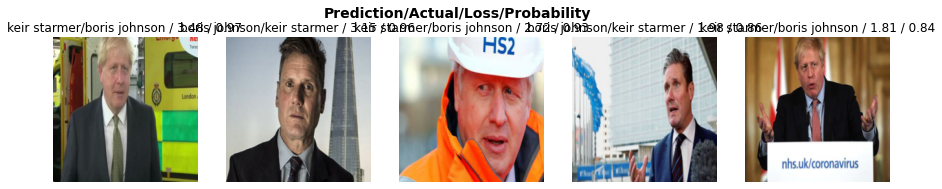

In [27]:
interp.plot_top_losses(5, nrows=1)

In [28]:
cleaner = vision_widgets.ImageClassifierCleaner(learn)
cleaner

FileNotFoundError: ignored

In [33]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), IMAGES/cat)

In [34]:
len(list(IMAGES.rglob('*')))

1494

In [35]:
!tar -czf $TARRED_DATA images/